# Boosted decision tree tutorial

***
## Introduction:
#### Boosted decision tree code:
We'll use the python API for the [XGBoost (eXtreme Gradient Boosting) library](https://github.com/dmlc/xgboost).

#### Data:
[Atlas](https://home.cern/about/experiments/atlas) hosted a [Kaggle](https://www.kaggle.com/) competition for identifying Higgs to tau tau events, [the Higgs Boson Machine Learning Challenge](https://www.kaggle.com/c/higgs-boson/data). The training data for this event contains 250,000 labeled, simulated Atlas events in csv format described [here](https://www.kaggle.com/c/higgs-boson/data) and [here](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). You can download it youself, or we have a small subset (10k events) in the "data" directory in this repository that we use here.

#### Data handling:
If you don't have [pandas](http://pandas.pydata.org/), you should get pandas. It's an amazing tool for exploring data in Python.
***
#### Install XGBoost:
Assuming you have python, numpy, matplotlib, and pandas installed, you just need to install XGBoost. Detailed installation instructions are [here](https://xgboost.readthedocs.io/en/latest/build.html). If you're on Ubuntu, just do this (in your terminal):
```bash
git clone --recursive https://github.com/dmlc/xgboost
cd xgboost
make
```
***
#### Links:
A lot of this was borrowed from other sources. These sources and other good places for information about XGBoost and BDTs in general are here:

XGBoost demo: [Example of how to use XGBoost Python Module to run Kaggle Higgs competition](https://github.com/dmlc/xgboost/tree/master/demo/kaggle-higgs)

Blog post by phunther: [Winning solution of Kaggle Higgs competition: what a single model can do?](https://no2147483647.wordpress.com/2014/09/17/winning-solution-of-kaggle-higgs-competition-what-a-single-model-can-do/)

XGBoost Kaggle Higgs solution: https://github.com/hetong007/higgsml

***

## Tutorial:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import awkward as ak
from sklearn.model_selection import train_test_split
import uproot
#!source ~/scripts/renew_cms.sh
import processor.BDT_analysis as BDT_analysis
from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import Tools.objects
# this is all very bad practice
# from Tools.objects import *
# from Tools.basic_objects import *
# from Tools.cutflow import *
# from Tools.config_helpers import *
# from Tools.triggers import *
# from Tools.btag_scalefactors import *
# from Tools.lepton_scalefactors import *
from Tools.nano_mapping import make_fileset, nano_mapping
from processor.meta_processor import get_sample_meta
from plots.helpers import makePlot, scale_and_merge

from klepto.archives import dir_archive
from processor.default_accumulators import desired_output, add_processes_to_output

#### Load data:

In [2]:
BDT_params = ["Most_Forward_pt",
              "HT",
              "LeadLep_eta",
              "LeadLep_pt",
              "LeadLep_dxy",
              "LeadLep_dz",
              "SubLeadLep_pt",
              "SubLeadLep_eta",
              "SubLeadLep_dxy",
              "SubLeadLep_dz",
              "nJet",
              "nbtag",
              "LeadJet_pt",
              "SubLeadJet_pt",
              "SubSubLeadJet_pt",
              "nElectron",
              "MET_pt",
              "LeadBtag_pt",
              "MT_LeadLep_MET",
              "MT_SubLeadLep_MET",
              "LeadLep_SubLeadLep_Mass"]

desired_output.update({"BDT_df": processor.column_accumulator(np.zeros(shape=(0,len(BDT_params)+1)))})

signal_fileset = {"signal":    ["/nfs-7/userdata/ksalyer/fcnc/fcnc_v6_SRonly_5may2021/2018/signal_hct_atop.root",
                                "/nfs-7/userdata/ksalyer/fcnc/fcnc_v6_SRonly_5may2021/2018/signal_hct_top.root"]
                 }
background_fileset = {"background": ["/nfs-7/userdata/ksalyer/fcnc/fcnc_v6_SRonly_5may2021/2018/ttjets.root"]}

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor

In [3]:
year = 2018
signal_output = processor.run_uproot_job(
    signal_fileset,
    "Events",
    BDT_analysis.nano_analysis(year=year, variations=[], accumulator=desired_output, BDT_params=BDT_params),
    exe,
    exe_args,
    chunksize=250000,
)
signal_BDT_params = pd.DataFrame(data=signal_output["BDT_df"].value, columns=(["event"]+BDT_params))

background_output = processor.run_uproot_job(
    background_fileset,
    "Events",
    BDT_analysis.nano_analysis(year=year, variations=[], accumulator=desired_output, BDT_params=BDT_params),
    exe,
    exe_args,
    chunksize=250000,
)
background_BDT_params = pd.DataFrame(data=background_output["BDT_df"].value, columns=(["event"]+BDT_params))

Preprocessing:   0%|          | 0/2 [00:00<?, ?file/s]

Processing:   0%|          | 0/2 [00:00<?, ?chunk/s]

/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:194: RuntimeWarning: Missing c

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:194: RuntimeWarning: Missing c

In [4]:
signal_BDT_params

,event,Most_Forward_pt,HT,LeadLep_eta,LeadLep_pt,LeadLep_dxy,LeadLep_dz,SubLeadLep_pt,SubLeadLep_eta,SubLeadLep_dxy,...,nbtag,LeadJet_pt,SubLeadJet_pt,SubSubLeadJet_pt,nElectron,MET_pt,LeadBtag_pt,MT_LeadLep_MET,MT_SubLeadLep_MET,LeadLep_SubLeadLep_Mass
0,150067.0,46.71875,176.71875,-0.530762,60.919895,0.004707,0.002321,13.553322,-0.451904,0.001003,...,1.0,79.1875,50.8125,46.71875,1.0,16.457537,50.8125,46.903820,46.903820,4.365503
1,361854.0,53.71875,395.93750,0.722290,45.285774,0.003031,0.002850,30.312050,1.162842,-0.000902,...,1.0,195.5000,93.5625,53.71875,1.0,18.356785,93.5625,4.613614,4.613614,21.110849
2,362712.0,95.62500,772.15625,-1.120117,111.009315,0.001216,-0.000068,47.420338,-0.258484,0.000368,...,2.0,188.7500,161.3750,122.00000,2.0,14.313177,188.7500,15.987062,15.987062,157.613770
3,365650.0,50.75000,434.65625,-1.703369,70.339981,0.000156,-0.002872,27.604317,-0.467651,0.000201,...,1.0,99.0625,97.4375,82.18750,1.0,17.131666,64.0000,49.533718,49.533718,59.476559
4,433790.0,87.25000,566.21875,-0.324768,150.970657,0.000613,0.005573,36.700115,-1.368652,-0.005867,...,1.0,165.6250,109.4375,100.75000,1.0,17.706202,109.4375,85.897255,85.897255,99.217606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,3165099.0,53.56250,409.21875,-0.674805,118.829987,0.000732,-0.002131,44.438999,-1.393066,-0.000610,...,1.0,134.1250,94.3125,77.37500,0.0,18.355410,77.3750,12.154293,12.154293,152.884644
3643,3166066.0,76.81250,336.53125,0.231293,94.485352,0.001725,-0.003119,32.333916,0.157684,0.000471,...,1.0,102.9375,100.5000,76.81250,1.0,14.020770,76.8125,2.004112,2.004112,110.588966
3644,3168212.0,127.37500,413.09375,2.260742,87.095459,0.000482,-0.002962,32.565693,1.343750,-0.002089,...,1.0,192.8750,127.3750,50.78125,2.0,19.536016,192.8750,49.968029,49.968029,99.229767
3645,3169184.0,51.25000,728.12500,0.047562,135.676422,-0.000058,0.003481,22.347967,-0.029160,-0.001070,...,1.0,160.8750,150.3750,138.75000,0.0,18.746605,138.7500,12.970442,12.970442,110.091255


In [5]:
year=2018
signal_BDT_params["Label"] = "s"
background_BDT_params["Label"] = "b"
background_BDT_params = background_BDT_params[:signal_BDT_params.shape[0]] #make the background only as large as the signal
full_data = pd.concat([signal_BDT_params, background_BDT_params], axis=0)
full_data

,event,Most_Forward_pt,HT,LeadLep_eta,LeadLep_pt,LeadLep_dxy,LeadLep_dz,SubLeadLep_pt,SubLeadLep_eta,SubLeadLep_dxy,...,LeadJet_pt,SubLeadJet_pt,SubSubLeadJet_pt,nElectron,MET_pt,LeadBtag_pt,MT_LeadLep_MET,MT_SubLeadLep_MET,LeadLep_SubLeadLep_Mass,Label
0,150067.0,46.71875,176.71875,-0.530762,60.919895,0.004707,0.002321,13.553322,-0.451904,0.001003,...,79.1875,50.81250,46.71875,1.0,16.457537,50.81250,46.903820,46.903820,4.365503,s
1,361854.0,53.71875,395.93750,0.722290,45.285774,0.003031,0.002850,30.312050,1.162842,-0.000902,...,195.5000,93.56250,53.71875,1.0,18.356785,93.56250,4.613614,4.613614,21.110849,s
2,362712.0,95.62500,772.15625,-1.120117,111.009315,0.001216,-0.000068,47.420338,-0.258484,0.000368,...,188.7500,161.37500,122.00000,2.0,14.313177,188.75000,15.987062,15.987062,157.613770,s
3,365650.0,50.75000,434.65625,-1.703369,70.339981,0.000156,-0.002872,27.604317,-0.467651,0.000201,...,99.0625,97.43750,82.18750,1.0,17.131666,64.00000,49.533718,49.533718,59.476559,s
4,433790.0,87.25000,566.21875,-0.324768,150.970657,0.000613,0.005573,36.700115,-1.368652,-0.005867,...,165.6250,109.43750,100.75000,1.0,17.706202,109.43750,85.897255,85.897255,99.217606,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,322692232.0,42.75000,332.12500,-0.531250,41.921757,-0.000250,-0.002235,20.596828,1.490967,-0.003605,...,141.2500,49.96875,49.62500,0.0,6.596288,141.25000,23.759729,23.759729,87.949783,b
3643,339118045.0,40.84375,431.03125,-0.535278,32.499413,-0.001214,0.000757,24.594938,-1.281982,0.002161,...,161.6250,157.75000,70.81250,0.0,11.543569,161.62500,0.557994,0.557994,39.972275,b
3644,147470015.0,45.40625,202.03125,-1.215088,50.670551,0.000249,0.002779,43.714466,-0.558350,-0.000749,...,67.5625,47.15625,45.40625,1.0,13.662038,45.40625,17.142179,17.142179,98.250374,b
3645,147603169.0,60.03125,368.65625,-0.523438,62.893581,-0.000995,0.001838,51.495441,-1.772461,0.000396,...,77.3125,77.00000,72.25000,0.0,13.506389,77.00000,16.929590,16.929590,94.797379,b


Let's see what the data looks like:

In [6]:
print('Size of data: {}'.format(full_data.shape))
print('Number of events: {}'.format(full_data.shape[0]))
print('Number of columns: {}'.format(full_data.shape[1]))

print ('\nList of features in dataset:')
for col in full_data.columns:
    print(col)

Size of data: (7294, 23)
Number of events: 7294
Number of columns: 23

List of features in dataset:
event
Most_Forward_pt
HT
LeadLep_eta
LeadLep_pt
LeadLep_dxy
LeadLep_dz
SubLeadLep_pt
SubLeadLep_eta
SubLeadLep_dxy
SubLeadLep_dz
nJet
nbtag
LeadJet_pt
SubLeadJet_pt
SubSubLeadJet_pt
nElectron
MET_pt
LeadBtag_pt
MT_LeadLep_MET
MT_SubLeadLep_MET
LeadLep_SubLeadLep_Mass
Label


Now we can look at how many events are signal and background:

In [7]:
# look at column labels --- notice last one is "Label" and first is "EventId" also "Weight"
print('Number of signal events: {}'.format(len(full_data[full_data.Label == 's'])))
print('Number of background events: {}'.format(len(full_data[full_data.Label == 'b'])))
print('Fraction signal: {}'.format(len(full_data[full_data.Label == 's'])/(float)(len(full_data[full_data.Label == 's']) + len(full_data[full_data.Label == 'b']))))

Number of signal events: 3647
Number of background events: 3647
Fraction signal: 0.5


#### Format data:
Now we should get the data into an XGBoost-friendly format. We can create DMatrix objects that will be used to train the BDT model. For now, we'll use all 30 of the features for training.

First, we'll sliceup the data into training and testing sets. Here, we take 20% for the test set, which is arbitrary.

In this file, all samples are independent and ordered randomly, so we can just grab a chunk. Check out [scikit-learn Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) for dividing up samples in a responsible way.

We can also change the data type of the "Label" column to the pandas type "category" for easier use later.

In [8]:
full_data['Label'] = full_data.Label.astype('category')
test1 = full_data[full_data["Label"] != "s"]

In [9]:
(data_train, data_test) = train_test_split(full_data, train_size=0.5)

Check to make sure we did it right:

In [10]:
print('Number of training samples: {}'.format(len(data_train)))
print('Number of testing samples: {}'.format(len(data_test)))

print('\nNumber of signal events in training set: {}'.format(len(data_train[data_train.Label == 's'])))
print('Number of background events in training set: {}'.format(len(data_train[data_train.Label == 'b'])))
print('Fraction signal: {}'.format(len(data_train[data_train.Label == 's'])/(float)(len(data_train[data_train.Label == 's']) + len(data_train[data_train.Label == 'b']))))

Number of training samples: 3647
Number of testing samples: 3647

Number of signal events in training set: 1806
Number of background events in training set: 1841
Fraction signal: 0.4952015355086372


The DMatrix object takes as arguments:
- data --- the features
- label --- 1/0 or true/false for binary data (we have to convert our label to bool from string s/b)
- missing --- how missing values are represented (here as -999.0)
- feature_names --- the names of all of the features (optional)

In [11]:
feature_names = full_data.columns[1:-1]  # we skip the first and last two columns because they are the ID, weight, and label
print(feature_names)
train = xgb.DMatrix(data=data_train[feature_names],label=data_train.Label.cat.codes,
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=data_test[feature_names],label=data_test.Label.cat.codes,
                   missing=-999.0,feature_names=feature_names)
print(data_test.Label.cat.codes)

Index(['Most_Forward_pt', 'HT', 'LeadLep_eta', 'LeadLep_pt', 'LeadLep_dxy',
       'LeadLep_dz', 'SubLeadLep_pt', 'SubLeadLep_eta', 'SubLeadLep_dxy',
       'SubLeadLep_dz', 'nJet', 'nbtag', 'LeadJet_pt', 'SubLeadJet_pt',
       'SubSubLeadJet_pt', 'nElectron', 'MET_pt', 'LeadBtag_pt',
       'MT_LeadLep_MET', 'MT_SubLeadLep_MET', 'LeadLep_SubLeadLep_Mass'],
      dtype='object')
1050    0
1806    0
1631    0
2665    0
759     0
       ..
2077    1
161     0
920     0
696     1
2366    1
Length: 3647, dtype: int8


Check if we did it right:

In [12]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))

print('\nNumber of signal events in training set: {}'.format(len(np.where(train.get_label())[0])))

Number of training samples: 3647
Number of testing samples: 3647

Number of signal events in training set: 1806


### Make the model
#### Set hyperparameters:
The XGBoost hyperparameters are defined [here](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md). For a nice description of what they all mean, and tips on tuning them, see [this guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

In general, the tunable parameters in XGBoost are the ones you would see in other gradient boosting libraries. Here, they fall into three categories:
1. General parameters - Ex. :which booster to use, number of threads. I won't mess with any of these here.
2. Booster parameters - Tune the actual boosting. Ex.: learning rate. These are the ones to optimize.
3. Learning task parameters - Define the objective function and the evaluation metrics.

Here, we will use the defaults for most parameters and just set a few to see how it's done. The parameters are passed in as a dictionary or list of pairs.

Make the parameter dictionary:

In [13]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

First, we set the booster parameters. Again, we just chose a few here to experiment with. These are the paraters to tune to optimize your model. Generally, there is a trade off between speed and accuracy.
1. ```eta``` is the learning rate. It determines how much to change the data weights after each boosting iteration. The default is 0.3.
2. ```max_depth``` is the maximum depth of any tree. The default is 6.
3. ```subsample``` is the fraction of events used to train each new tree. These events are randomly sampled each iteration from the whole sample set. The default is 1 (use every event for each tree).
4. ```colsample_bytree``` is the fraction of features available to train each new tree. These features are randomly sampled each iteration from the whole feature set. The default is 1.

Next, we set the learning objective to ```binary:logistic```. So, we have two classes that we want to score from 0 to 1. The ```eval_metric``` parameters set what we want to monitor when doing cross validation. (We aren't doing cross validation in this example, but we really should be!) If you want to watch more than one metric, ```param``` must be a list of pairs, instead of a dict. Otherwise, we would just keep resetting the same parameter.

Last, we set thenumber of trees to 100. Usually, you would set this number high, and choose a cut off point based on the cross validation. The number of trees is the same as the number of iterations.

### Now train!

In [14]:
booster = xgb.train(param,train,num_boost_round=num_trees)

We now have a trained model. The next step is to look at it's performance and try to improve the model if we need to. We can try to improve it by improving/adding features, adding more training data, using more boosting iterations, or tuning the hyperparameters (ideally in that order).

#### Evaluate:
First, let's look at how it does on the test set:

In [15]:
print(booster.eval(test))

[0]	eval-error:0.292569	eval-logloss:0.613850	eval-rmse:0.451306


These are the evaluation metrics that we stored in the parameter set.

It's pretty hard to interpret the performance of a classifier from a few number. So, let's look at the predictions for the entire test set.

In [16]:
predictions = booster.predict(test)
train_predictions = booster.predict(train)

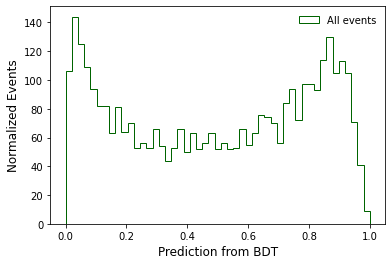

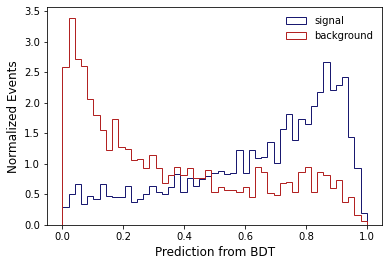

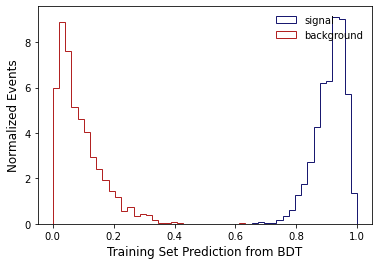

In [19]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Normalized Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal', density=True);
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background', density=True);
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Normalized Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(train_predictions[train.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal', density=True);
plt.hist(train_predictions[~(train.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background', density=True);
# make the plot readable
plt.xlabel('Training Set Prediction from BDT',fontsize=12);
plt.ylabel('Normalized Events',fontsize=12);
plt.legend(frameon=False);

<ipython-input-20-b999a9ad69be>:11: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nsignal/len(data_test[data_test.Label == 's']),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
No handles with labels found to put in legend.


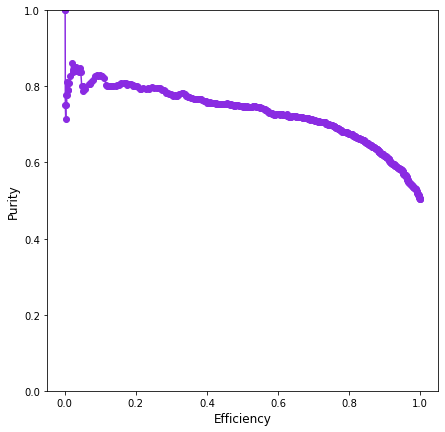

In [20]:
# choose score cuts:
cuts = np.linspace(0,1,500);
nsignal = np.zeros(len(cuts));
nbackground = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0]);
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0]);
    
# plot efficiency vs. purity (ROC curve)
plt.figure(figsize=(7,7));
plt.plot(nsignal/len(data_test[data_test.Label == 's']),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.ylim([0, 1])
plt.legend(frameon=False);

It's also very informative to look at the importance of each feature. The "F score" is the number of times each feature is used to split the data over all of the trees (times the weight of that tree).

There is a built-in function in the XGBoost python API to easily plot this:

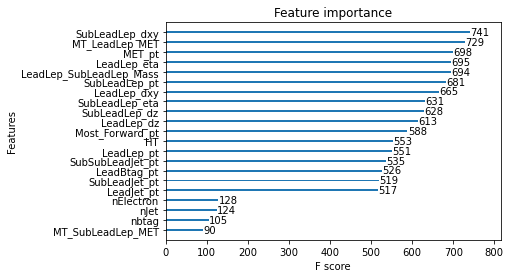

In [21]:
xgb.plot_importance(booster,grid=False);

In [25]:
labels = BDT_params

bins_dict = {"Most_Forward_pt":np.linspace(10,120,30),
          "HT":np.linspace(80,1000,30),
          "LeadLep_eta":np.linspace(0,2.4,15),
          "MET_pt":np.linspace(0,200,30),
          "LeadLep_pt":np.linspace(10,200,30),
          "LeadLep_dxy":np.linspace(0,0.015,30),
          "LeadLep_dz":np.linspace(0,0.02,30),
          "SubLeadLep_pt":np.linspace(10,120,30),
          "SubLeadLep_eta":np.linspace(0,2.4,15),
          "SubLeadLep_dxy":np.linspace(0,0.015,30),
          "SubLeadLep_dz":np.linspace(0,0.02,30),
          "nJet":np.linspace(1.5,13.5,12),
          "LeadJet_pt":np.linspace(10,200,30),
          "SubLeadJet_pt":np.linspace(10,200,30),
          "SubSubLeadJet_pt":np.linspace(10,200,30),
          "nElectron":np.linspace(1.5,6.5,5),
          "MT_LeadLep_MET":np.linspace(0,240,30),
          "MT_SubLeadLep_MET":np.linspace(0,240,30),
          "LeadBtag_pt":np.linspace(0,200,30),
          "nbtag":np.linspace(1.5,6.5,5),
          "LeadLep_SubLeadLep_Mass":np.linspace(0, 200, 30)
          }

def gen_hist(label, savefig=False):
    plt.figure(label, figsize=(6,6));
    bins = bins_dict[label]
    values_signal = np.abs(data_train[label][data_train.Label == 's'])
    values_background = np.abs(data_train[label][data_train.Label == 'b'])
    plt.hist(np.clip(values_signal, bins[0], bins[-1]),bins=bins_dict[label],
             histtype='step',color='midnightblue',label='signal', density=True);
    plt.hist(np.clip(values_background, bins[0], bins[-1]),bins=bins_dict[label],
             histtype='step',color='firebrick',label='background', density=True);

    plt.xlabel(label,fontsize=12);
    plt.ylabel('Normalized Counts',fontsize=12);
    plt.legend(frameon=False);
    if savefig:
        plt.savefig("/home/users/cmcmahon/public_html/BDT/histograms/{}.pdf".format(label))
    plt.draw()
    

We can plot how our features are ditributed for the signal and background:

<ipython-input-25-4f3e7de329b0>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(label, figsize=(6,6));


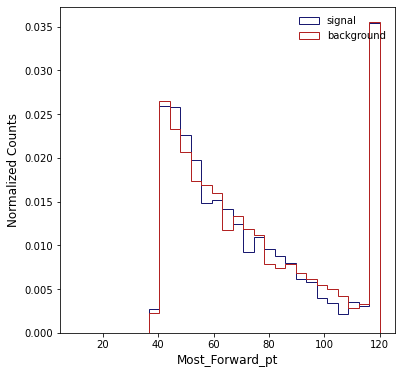

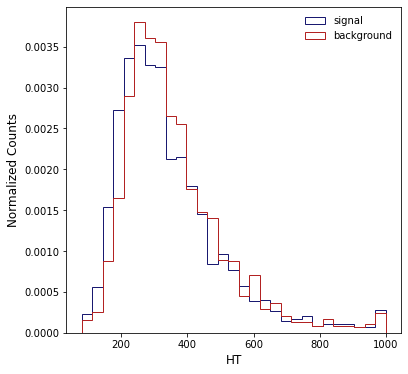

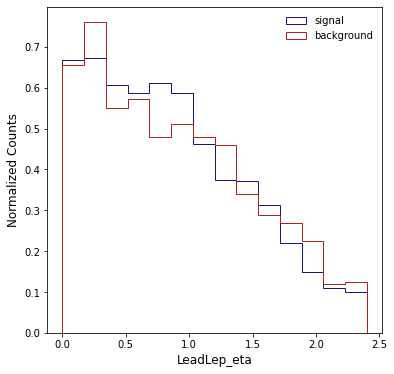

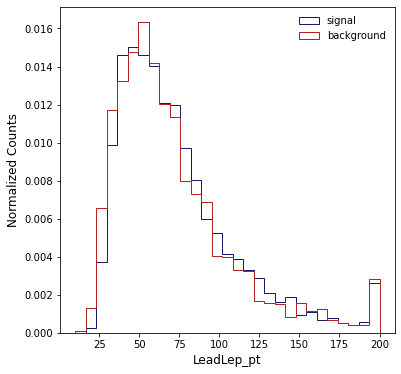

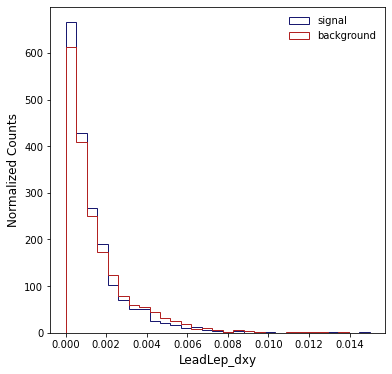

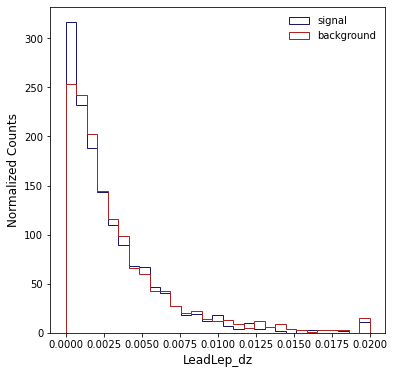

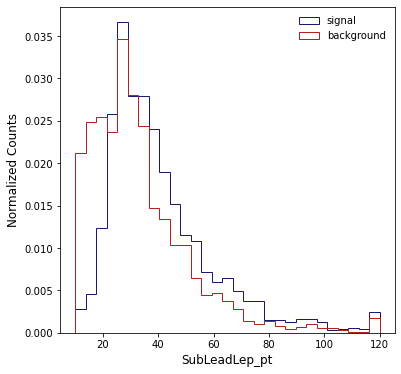

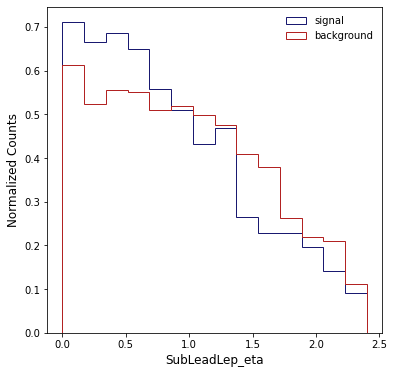

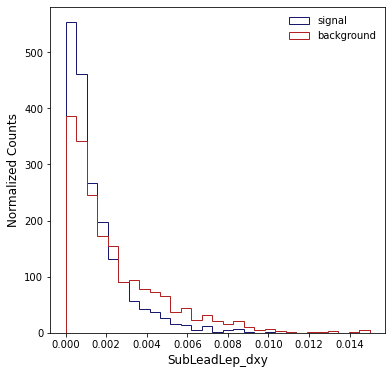

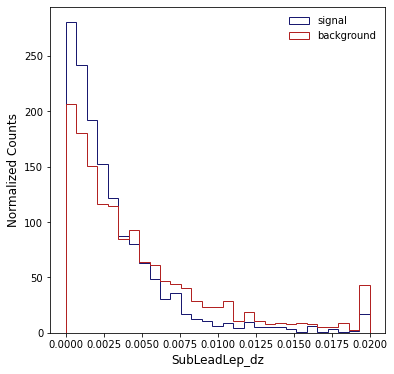

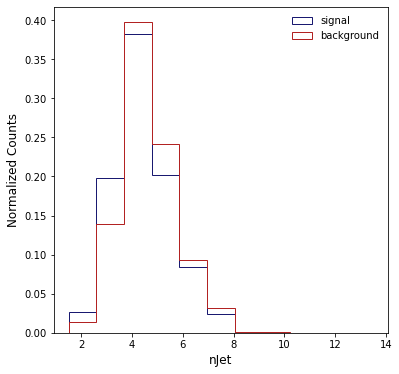

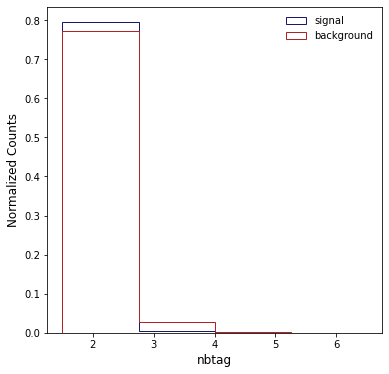

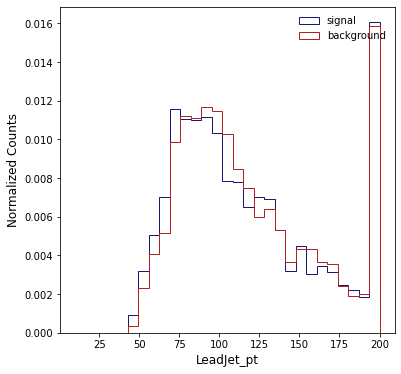

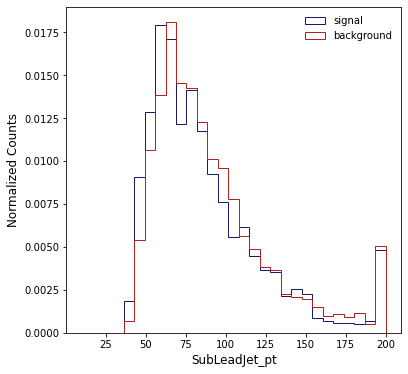

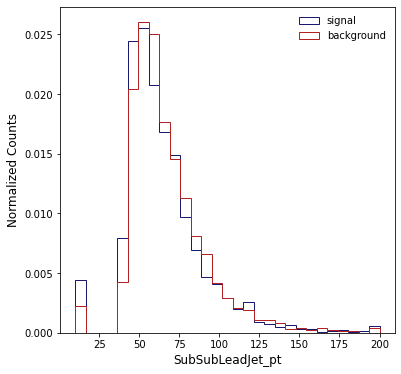

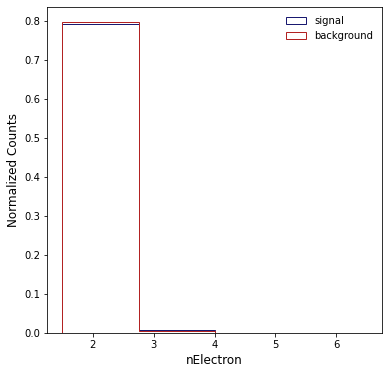

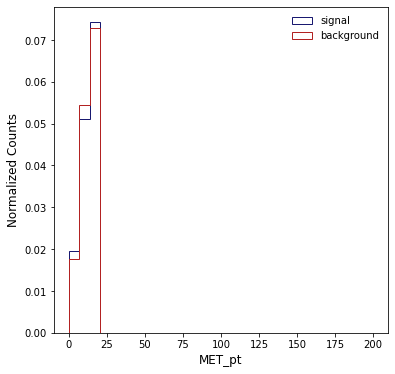

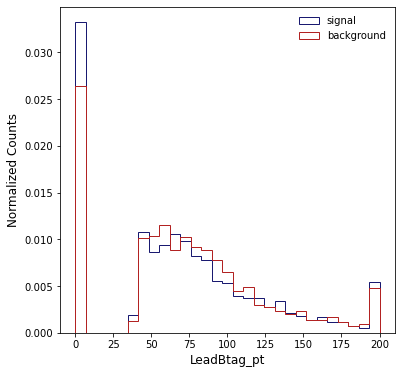

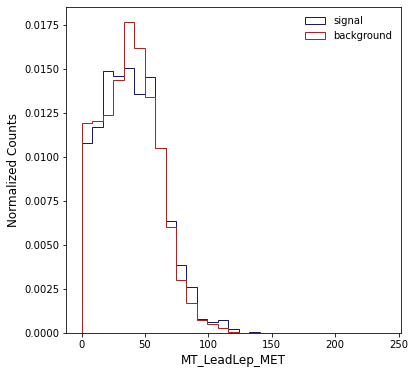

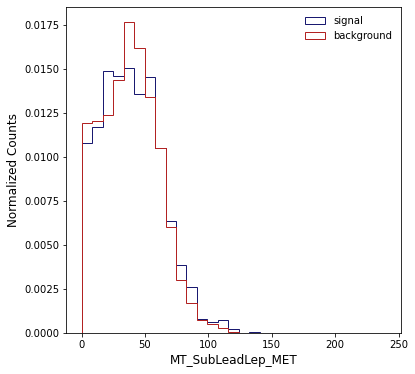

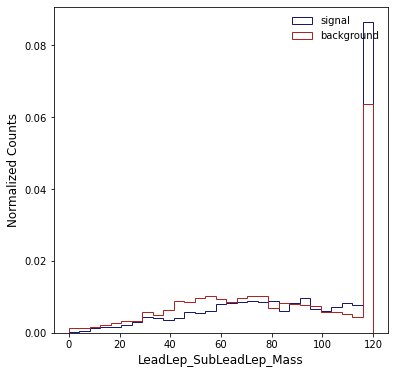

In [26]:
for label in labels:
    gen_hist(label, savefig=True)

NameError: name 'd' is not defined

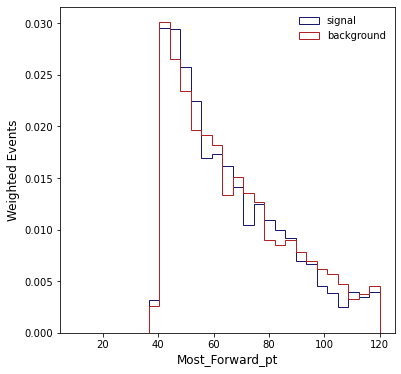

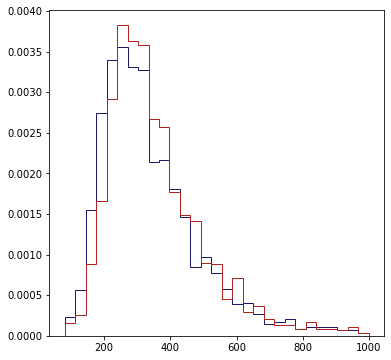

In [24]:
plt.figure("forward_pt", figsize=(6,6));
plt.hist(data_train.Most_Forward_pt[data_train.Label == 's'],bins=np.linspace(10,120,30),
         histtype='step',color='midnightblue',label='signal', density=True);
plt.hist(data_train.Most_Forward_pt[data_train.Label == 'b'],bins=np.linspace(10,120,30),
         histtype='step',color='firebrick',label='background', density=True);

plt.xlabel('Most_Forward_pt',fontsize=12);
plt.ylabel('Weighted Events',fontsize=12);
plt.legend(frameon=False);

plt.figure("HT", figsize=(6,6));
plt.hist(data_train.HT[data_train.Label == 's'],bins=np.linspace(80,1000,30),
         histtype='step',color='midnightblue',label='signal', density=True);
plt.hist(data_train.HT[data_train.Label == 'b'],bins=np.linspace(80,1000,30),
         histtype='step',color='firebrick',label='background', density=True);
d
plt.xlabel('HT',fontsize=12);
plt.ylabel('Weighted Events',fontsize=12);
plt.legend(frameon=False);

plt.figure("LeadLep_eta", figsize=(6,6));
plt.hist(np.abs(data_train.LeadLep_eta[data_train.Label == 's']),bins=np.linspace(0,2.4,30),
         histtype='step',color='midnightblue',label='signal', density=True);
plt.hist(np.abs(data_train.LeadLep_eta[data_train.Label == 'b']),bins=np.linspace(0,2.4,30),
         histtype='step',color='firebrick',label='background', density=True);

plt.xlabel('LeadLep_eta',fontsize=12);
plt.ylabel('Weighted Events',fontsize=12);
plt.legend(frameon=False);

plt.figure("MET", figsize=(6,6));
plt.hist(np.abs(data_train.MET_pt[data_train.Label == 's']),bins=np.linspace(0,200,30),
         histtype='step',color='midnightblue',label='signal', density=True);
plt.hist(np.abs(data_train.MET_pt[data_train.Label == 'b']),bins=np.linspace(0,200,30),
         histtype='step',color='firebrick',label='background', density=True);

plt.xlabel('MET_pt',fontsize=12);
plt.ylabel('Weighted Events',fontsize=12);
plt.legend(frameon=False);

plt.figure("leadlep_pt", figsize=(6,6));
plt.hist(np.abs(data_train.LeadLep_pt[data_train.Label == 's']),bins=np.linspace(0,200,30),
         histtype='step',color='midnightblue',label='signal', density=True);
plt.hist(np.abs(data_train.LeadLep_pt[data_train.Label == 'b']),bins=np.linspace(0,200,30),
         histtype='step',color='firebrick',label='background', density=True);

plt.xlabel('LeadLep_pt',fontsize=12);
plt.ylabel('Weighted Events',fontsize=12);
plt.legend(frameon=False);

There is not a lot of discriminating power in that variable. For fun, we can plot it with the next most important feature:

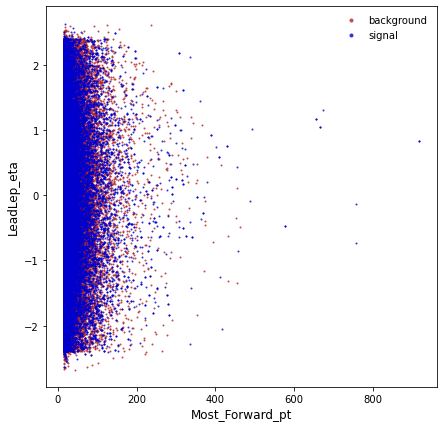

In [174]:
plt.figure("2d", figsize=(7,7));
plt.plot(data_train.Most_Forward_pt[data_train.Label == 'b'],data_train.LeadLep_eta[data_train.Label == 'b'],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='background');
plt.plot(data_train.Most_Forward_pt[data_train.Label == 's'],data_train.LeadLep_eta[data_train.Label == 's'],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal');
plt.xlabel('Most_Forward_pt',fontsize=12);
plt.ylabel('LeadLep_eta',fontsize=12);
plt.legend(frameon=False,numpoints=1,markerscale=2);

### Old way of getting BDT parameters

In [ ]:
def gen_BDT_data(tree, label = "s", year=2018):
    #get variables
    leptons_pt = ak.concatenate([tree.arrays("Muon_pt")["Muon_pt"], tree.arrays("Electron_pt")["Electron_pt"]], axis=1)
    leptons_eta = ak.concatenate([tree.arrays("Muon_eta")["Muon_eta"], tree.arrays("Electron_eta")["Electron_eta"]], axis=1)
    leptons_phi = ak.concatenate([tree.arrays("Muon_phi")["Muon_phi"], tree.arrays("Electron_phi")["Electron_phi"]], axis=1)
    leptons_dxy = ak.concatenate([tree.arrays("Muon_dxy")["Muon_dxy"], tree.arrays("Electron_dxy")["Electron_dxy"]], axis=1)
    leptons_dz = ak.concatenate([tree.arrays("Muon_dz")["Muon_dz"], tree.arrays("Electron_dz")["Electron_dz"]], axis=1)
    leptons_mass = ak.concatenate([tree.arrays("Muon_mass")["Muon_mass"], tree.arrays("Electron_mass")["Electron_mass"]], axis=1)
    #breakpoint()
    MET_pt = tree.arrays("MET_pt")["MET_pt"]
    MET_phi = tree.arrays("MET_phi")["MET_phi"]
    jet_pt = tree.arrays("Jet_pt")["Jet_pt"]
    jet_eta = tree.arrays("Jet_eta")["Jet_eta"]
    jet_btag_flav = tree.arrays("Jet_btagDeepFlavB")["Jet_btagDeepFlavB"]    
    #calculate relevant parameters
    btag_reqs = {2016:0.3093, 2017:0.3033, 2018:0.2770}
    btag_selection = jet_btag_flav > btag_reqs[year]
    jet_btag = jet_btag_flav[btag_selection]
    nbtag = ak.num(jet_btag, axis=1)
    #sort parameters
    sorted_index = ak.argsort(leptons_pt, axis=-1, ascending=False)
    sorted_pt = leptons_pt[sorted_index]
    sorted_eta = leptons_eta[sorted_index]
    sorted_phi = leptons_phi[sorted_index]
    sorted_dxy = leptons_dxy[sorted_index]
    sorted_dz = leptons_dz[sorted_index]
    
    sorted_jet_index = ak.argsort(jet_pt, axis=-1, ascending=False)
    sorted_jet_pt = jet_pt[sorted_jet_index]
    
    leadlep_pt = ak.max(leptons_pt, axis=1)
    subleadlep_pt = ak.flatten(sorted_pt[:,1:2])
    leadlep_eta = ak.flatten(leptons_eta[ak.singletons(ak.argmax(leptons_pt, axis=1))])
    subleadlep_eta = ak.flatten(sorted_eta[:,1:2])
    leadlep_phi = ak.flatten(leptons_phi[ak.singletons(ak.argmax(leptons_pt, axis=1))])
    subleadlep_phi = ak.flatten(sorted_phi[:,1:2])
    leadlep_dxy = ak.flatten(sorted_dxy[:,0:1])
    subleadlep_dxy = ak.flatten(sorted_dxy[:,1:2])    
    leadlep_dz = ak.flatten(sorted_dz[:,0:1])
    subleadlep_dz = ak.flatten(sorted_dz[:,1:2])
    
    leadjet_pt = ak.max(jet_pt, axis=1)
    subleadjet_pt = ak.flatten(sorted_jet_pt[:,1:2])
    #this sometimes is not defined, so ak.firsts relpaces the empty arrays with None, then we can set all None to zero
    subsubleadjet_pt = ak.fill_none(ak.firsts(sorted_jet_pt[:,2:3]), 0) 

    sorted_btag_selection = btag_selection[sorted_jet_index]
    sorted_btag_pt = sorted_jet_pt[sorted_btag_selection]
    leadbtag_pt = sorted_btag_pt[:,0:1] #this sometimes is not defined (some of the arrays are empty)
    # ak.firsts() relpaces the empty arrays with None, then we can set all None to zero
    leadbtag_pt = ak.fill_none(ak.firsts(leadbtag_pt), 0)
    
    most_forward_pt = ak.flatten(jet_pt[ak.singletons(ak.argmax(abs(jet_eta), axis=1))])
    
    HT = ak.sum(jet_pt, axis=1) #maybe have to clean this?
    #MT calculation
    mt_leadlep_met = helpers.mt(leadlep_pt, leadlep_phi, MET_pt, MET_phi)
    mt_subleadlep_met = helpers.mt(subleadlep_pt, subleadlep_phi, MET_pt, MET_phi)
    
    #make a pandas df
    data= ak.to_pandas(tree.arrays(["nJet", "MET_pt", "nElectron"]))
    data["nbtag"] = nbtag
    data["LeadLep_pt"] = leadlep_pt
    data["LeadLep_eta"] = leadlep_eta
    data["LeadLep_dxy"] = leadlep_dxy
    data["LeadLep_dz"] = leadlep_dz
    data["SubLeadLep_pt"] = subleadlep_pt
    data["SubLeadLep_eta"] = subleadlep_eta
    data["SubLeadLep_dxy"] = subleadlep_dxy
    data["SubLeadLep_dz"] = subleadlep_dz 
    data["Most_Forward_pt"] = most_forward_pt
    data["MT_LeadLep_MET"] = mt_leadlep_met
    data["MT_SubLeadLep_MET"] = mt_subleadlep_met
    data["LeadBtag_pt"] = leadbtag_pt
    data["LeadJet_pt"] = leadjet_pt
    data["SubLeadJet_pt"] = subleadjet_pt
    data["SubSubLeadJet_pt"] = subsubleadjet_pt
    data["HT"] = HT
    data["Label"] = label
    return data


# SR_tree_atop = uproot.open('/nfs-7/userdata/ksalyer/fcnc/fcnc_v6_SRonly_5may2021/2018/signal_hct_atop.root')['Events']
# SR_tree_top = uproot.open('/nfs-7/userdata/ksalyer/fcnc/fcnc_v6_SRonly_5may2021/2018/signal_hct_top.root')['Events']
# BR_tree = uproot.open('/nfs-7/userdata/ksalyer/fcnc/fcnc_v6_SRonly_5may2021/2018/ttjets.root')['Events']
# print(SR_tree_atop.keys())
year=2018
SR_data_atop = gen_BDT_data(SR_tree_atop, "s", year)
SR_data_top = gen_BDT_data(SR_tree_top, "s", year)
SR_data = pd.concat([SR_data_atop, SR_data_top], axis=0)
def gen_preselection(data):
    preselection = (data["LeadLep_pt"] > 20) & (data["SubLeadLep_pt"] > 20) & (data["nJet"] > 1)
    return preselection

SR_data = SR_data[gen_preselection(SR_data)]
BR_data = gen_BDT_data(BR_tree, "b")
BR_data = BR_data[gen_preselection(BR_data)]
BR_data = BR_data[:SR_data.shape[0]] #make the background only as large as the signal
full_data = pd.concat([SR_data, BR_data], axis=0)
full_data